In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\Uncompress\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

Create working dir and unzip all files if needed

In [4]:
def getLegendNumber(image, reader):

    im_arry = np.asarray(image).astype(np.uint8) * 255
    im_arry_crop = im_arry[int(-0.05 * im_arry.shape[0]):, int(-0.1 * im_arry.shape[1]):]
    im_arry_crop = cv2.GaussianBlur(im_arry_crop, (1, 1), 1, 1)

    im_scan = reader.readtext(im_arry_crop, detail=1, text_threshold=0.9)

    if len(im_scan) == 0:
        return None

    best = np.argmax([a[-1] for a in im_scan])

    text = re.sub('[^0-9]', "", im_scan[best][1])
    if text == '':
        return None

    return text


In [5]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                prev_counter = 0
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    if i == 0:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_IND{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    else:
                        try:
                            img.seek(i)
                            text = getLegendNumber(np.asarray(img), reader)

                            if text is not None:
                                output_filename = f"{os.path.splitext(tiff_file)[0]}_{text}.tif"
                                img.save(output_filename, format=img.format)
                                prev_counter = int(text)
                            
                            else:
                                prev_counter = prev_counter+1
                                output_filename = f"{os.path.splitext(tiff_file)[0]}_unsure_{prev_counter}.tif"
                                img.save(output_filename, format=img.format)
                        except:
                            print(f"Error with {tiff_file} page {i}")
                            print(traceback.format_exc())
                            continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
   os.remove(tiff_file)

  0%|          | 0/1704 [00:00<?, ?it/s]

Error opening D:\RECTDNN\Uncompress\485479B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479B.tif'
Error opening D:\RECTDNN\Uncompress\485479C.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479C.tif'
Error opening D:\RECTDNN\Uncompress\485481A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485481A.tif'
Error opening D:\RECTDNN\Uncompress\485510.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510.tif'
Error opening D:\RECTDNN\Uncompress\485510B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510B.tif'
Error opening D:\RECTDNN\Uncompress\485514B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485514B.tif'
Error opening D:\RECTDNN\Uncompress\485516A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485516A.tif'


In [6]:
# MAKE PROCESSING DIRECTORY
# datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# proc_dir     = os.path.join(base_output_path, datetime_str)
proc_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\\"

# IF THERE ARE ANY ZIP FILES IN DIRECTORY, UNZIP THEM IN PLACE
if len(glob.glob(base_input_path + "*.zip*")) != 0:
    extractZipFiles(base_input_path, base_input_path)

outputs_dir  = os.path.join(proc_dir, "Outputs")
os.makedirs(outputs_dir, exist_ok=True)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first in-place at uncompressed directory

In [7]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
    os.remove(tiff_file)

  0%|          | 0/1704 [00:00<?, ?it/s]

Error opening D:\RECTDNN\Uncompress\485479B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479B.tif'
Error opening D:\RECTDNN\Uncompress\485479C.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479C.tif'
Error opening D:\RECTDNN\Uncompress\485481A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485481A.tif'
Error opening D:\RECTDNN\Uncompress\485510.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510.tif'
Error opening D:\RECTDNN\Uncompress\485510B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510B.tif'
Error opening D:\RECTDNN\Uncompress\485514B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485514B.tif'
Error opening D:\RECTDNN\Uncompress\485516A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485516A.tif'


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [8]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{base_input_path}/*480287*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*480287*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)
index_files = [a for a in index_files if "unsure" not in a]

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

In [9]:
index_files

FilePath             Basename  Location  \
0      D:\RECTDNN\Uncompress\480287B_IND.tif      480287B_IND.tif    480287   
1  D:\RECTDNN\Uncompress\480287IND0_0281.jpg  480287IND0_0281.jpg    480287   
2  D:\RECTDNN\Uncompress\480287IND0_0288.jpg  480287IND0_0288.jpg    480287   
3  D:\RECTDNN\Uncompress\480287IND0_0382.jpg  480287IND0_0382.jpg    480287   
4  D:\RECTDNN\Uncompress\480287IND0_0985.jpg  480287IND0_0985.jpg    480287   

   GEOID                                           geometry  
0  48201  POLYGON ((-10670735.842366695 3487438.18108206...  
1  48201  POLYGON ((-10670735.842366695 3487438.18108206...  
2  48201  POLYGON ((-10670735.842366695 3487438.18108206...  
3  48201  POLYGON ((-10670735.842366695 3487438.18108206...  
4  48201  POLYGON ((-10670735.842366695 3487438.18108206...

This is where we perform the ICP for each index...

In [10]:
verbose = True

TPNN = None
RLNN = None
CLNN = None
TLNN = None

# THIS CHECKS WHETHER THE RUN WAS INTERRUPTED
# TO MAKE SURE WE'RE NOT STARTING FROM SCRATCH UNNECESSARILY
try:
    gen_dict
    print("Starting with predefined dict")
except:
    gen_dict = {}

gen_dict = {}

# OUTPUT DIRECTORY FOR GENERAL RESULTS STRUCTURE
output_struct_dir = os.path.join(outputs_dir, "IndexCoords.pkl")

if not os.path.exists(output_struct_dir):
    for i, row in tqdm(index_files.iterrows(), total=index_files.shape[0]):
        
        try:

            filename = os.path.basename(row["FilePath"])
            
            # THIS CHECKS WHETHER THIS PARTICULAR RASTER WAS RUN ALREADY BY USING THE INDIVIDUAL PKL FILE
            if os.path.exists(os.path.join(outputs_dir, f"{filename}.pkl")):
                print(f"Skipping, found {os.path.join(outputs_dir, filename + '.pkl')}")
                continue

            # READ FILES AND CONVERT TO GRAYSCALE
            image = cv2.imread(row["FilePath"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_arry = np.asarray(image)
            
            # SAVE IMAGE TO OUTPUT DIRECTORY
            output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
            copyfile(row["FilePath"], output_image_fn)

            # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
            output = getBoundaryPoints(row, distance=100) # TODO: THIS IS THE SAME AS OUR APPROX ACCURACY - MAYBE MAKE IT TIGHTER? 
            if output is None:
                print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
                continue
            point_boundary_gdf, shp_bounds = output
            
            # RUN IMAGES THROUGH DNNs
            classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'])
            effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
            countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
            tiles, TLNN            = runTLNN(row['FilePath'], outputs_dir, TLNN=TLNN)

            dnn_outputs = {
                "classifications"   : classifications,
                "effectiveArea"     : effectiveArea,
                "countyArea"    : countyArea,
                "tiles"         : tiles
            }
            
            # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
            # bounds_panels = tiles["county"]["bbox"]
            bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

            # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
            if point_boundary_gdf is None:
                continue

            # DEFINE BOUNDARY STRUCTU
            boundaries = {
                "point_boundary_gdf"    : point_boundary_gdf,
                "shp_bounds"            : shp_bounds,
                "bounds_panels"         : bounds_panels,
            }

            # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
            key = findKey(row["Basename"])    
            if key is None:
                print(f"Could not find key in {filename}")
            
            # DO ICP
            transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=False, shear=False, perspective=False, icp_iterations=30, proc_limit=500)

            # GET TRANSFORM FROM ICP TO CRS TRANSFORM
            output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

            # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
            output_affine = Affine(*output_transform.flatten()[:6])
            with rio.open(output_image_fn, 'w',
                driver='GTiff',
                height=image.shape[0], width=image.shape[1],
                count=1, dtype=image.dtype,
                crs=f'EPSG:3857',
                transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                    dst.write(image, 1)   

            tiles['transform_info'] = transform_dict
            tiles['output_transform'] = output_transform
            tiles['DNN_outputs'] = dnn_outputs
            gen_dict[filename] = tiles
            
            with open(os.path.join(outputs_dir, f"{filename}.pkl"), 'wb') as handle:
                pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception: 
            print(f'Error with {os.path.basename(row["FilePath"])}')
            print(traceback.format_exc())
            continue
    
    # SAVE AS GENERAL OUTPUT
    with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
        pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(output_struct_dir, 'rb') as f:
        gen_dict = pickle.load(f)

In [11]:
for i, (k, v) in enumerate(gen_dict.items()):
    print(k)

480296A_IND.tif
480296IND0_0982.jpg
480296IND0_0985.jpg
480296IND0_0987.jpg
480296IND0_1279.jpg
480296A_unsure_1.tif


In [12]:
# os.path.basename(index_files.loc[0]['FilePath']    
tile_coords = smartifyDict(gen_dict, base_input_path, reader, verbose=0)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
          
with open(os.path.join(proc_dir, "SmartDict.p"), 'wb') as handle:
    pickle.dump(tile_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/OSM_Roads/TexasRoads_filtered_strict_3857_nondupe_smaller.gpkg", engine='pyogrio', use_arrow=True)
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)
init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

Which tiles are we processing?

In [15]:
# LIST ALL IMAGES IN DIRECTORY
image_files = []
# wildcards = ['480287', '48201']
wildcards = ['480296']
for w in wildcards:
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)
index_files = [a for a in index_files if "unsure" not in a]

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

Build tile database for detections in images

In [16]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(gen_dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

87 50


Supplement tile database with existing world files

In [17]:
fn = os.path.join(proc_dir, "WorldFileDatabase.feather")
if os.path.exists(fn):
    df = pd.read_pickle(fn)
else:
    df = buildWorldFileDatabase(base_input_path, duplicate_db, stateplanes)
    df.to_pickle(fn)

Save both databases as shapefiles

In [18]:
# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

gdf.to_file(os.path.join(proc_dir, "WorldFiles.shp"))
detected_tiles_gdf.to_file(os.path.join(proc_dir, "Detected.shp"))

12/15/2024 20:20:37 - WARNING - fiona._env -   Normalized/laundered field name: 'county_polygon' to 'county_pol'
12/15/2024 20:20:37 - WARNING - fiona._env -   Normalized/laundered field name: 'geotransform' to 'geotransfo'


In [19]:
referencing_dir  = os.path.join(proc_dir, "referencing") + "\\"
os.makedirs(referencing_dir, exist_ok=True)

def find_file_with_extension(filename, allowed_extensions, directory):
    for ext in allowed_extensions:
        file_path = os.path.join(directory, f"{filename}.{ext}")
        if os.path.isfile(file_path):
            return file_path
    return None 

counter = 0
bad_counter = 0

# FOR EACH TILE IN THE BASENAME
for tile_name in (pbar := tqdm(tiles_bns)): # tile_names: 
    ref_dir = f"{referencing_dir}{tile_name}.tif"
    if os.path.exists(ref_dir):
        print(f"Found {ref_dir}")
        continue

    # PRETTIFY PPROGRESS BAR AND VERBOSE OUTPUT
    pbar.set_description(f"Bad counter: {bad_counter}")
    counter = counter
    print(f"Processing {tile_name}" + "-" * 50)
    
    # FIND THE CORRECT FILE NAME FOR 
    im_file = find_file_with_extension(tile_name, ['tif', 'jpg', 'png'], base_input_path)

    # MAYBE THE IMAGE FILE WAS NOWHERE TO BE FOUND
    if im_file is None:
        print(f"COULD NOT FIND {tile_name} IMAGE " + '-' * 20)
        continue

    # CURRENT TILE PARAMETERS
    curr_tn = os.path.basename(im_file.split(".")[0])[:-1]  # TILE BASE NAME
    curr_tf = os.path.basename(im_file.split(".")[0])[-1]   # TILE EXTENSION (INDIVIDUAL LETTER)

    # READ TILE IN RASETERIO
    ra = rio.open(im_file)
    bounds  = ra.bounds
    image   = ra.read(1)

    # GET THE BOUNDS USING RLNN - TODO: CHECK LOADING TIMES HERE
    bounds, RLNN = findBounds(im_file, None)

    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        # ASSUME DATE IS IN LOWER RIGHT OF IMAGE
        # TODO: WE ARE USING DIFFERENT FOR LEGEND - USE THAT INSTEAD.
        datebox = [bbox[2], int(3 * image.shape[0] // 4), image.shape[1], image.shape[0]]


    current_tile_coords = tile_coords.get(curr_tn, None)
    if current_tile_coords is None:
        sec_level = re.sub(r'[a-zA-Z]', '', os.path.basename(im_file.split(".")[0]))
        sec_level = re.sub(r'__', '_', sec_level)
        print(f"Couldn't find strict, now trying {sec_level}")
        current_tile_coords = tile_coords.get(sec_level, None)
        if current_tile_coords is None:
            print(f"Could not find tile in detections {sec_level}")
            bad_counter = bad_counter + 1
            continue
        curr_tn = sec_level
        curr_tf = 0
    
    # GET DATE OF CURRENT TILE FROM DATEBOX, FILTERING WITH HEURISTICS (REVISED, EFFECTIVE)
    tile_datetime = extractDate(image[datebox[1]:datebox[3], datebox[0]:datebox[2]], reader, imsize=4092, filter_values=['revised', 'effective'])

    # CHECK IF WE FOUND A DATE, AND PROCEED ACCORDINGLY
    if tile_datetime[0] is not None: 
        # IF FOUND, FIND CLOSEST DATE WITHIN CURRENT KEY
        curr_bbox, closest_date = getBBOXClosestDate(extractDatesFromDict(tile_coords[curr_tn], curr_tf), tile_datetime[0][0])

        # IF CLOSEST DATE WITHIN CURRENT KEY IS OVER 10 YEARS, RETRY WITH ENTIRE DICT
        if abs(closest_date - tile_datetime[0][0]).days > 3650:
            curr_bbox, closest_date_gen = getBBOXClosestDate(extractDatesFromDict(tile_coords[curr_tn], 0), tile_datetime[0][0])
            print(f"CLOSEST DATE IN KEY IS TOO FAR ({abs(closest_date - tile_datetime[0][0]).days} days), using general instead ({closest_date_gen})")
    else: 
        print(f"Could not find date in {tile_datetime[1]}, trying to use {curr_tf}")
        # IF NOT FOUND, USE DEFAULT (0)
        current_tf_coords = current_tile_coords.get(curr_tf, None)
        if current_tf_coords is None:
            print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]} from options {current_tile_coords.keys()}")
            curr_tf = list(current_tile_coords.keys())[0]
            curr_bbox = tile_coords[curr_tn][curr_tf]["coords"][0]
        else:
            curr_bbox = current_tf_coords["coords"][0]

    # BOUND BBOX COORDINATE CONVERSIONS
    real_x, real_y = bbox_to_coords_realworld(curr_bbox)
    pic_x, pic_y   = bbox_to_coords_raster(bbox)
    affine = affineTransformation(pic_x, pic_y, real_x, real_y)
    transform = bboxTransformToCRS(affine.matrix, image)

    # OUTPUT NAME DIRECTORY FOR TILES
    

    with rio.open(ref_dir, 'w',
        driver='GTiff', count=1, dtype=image.dtype,
        height=image.shape[0], width=image.shape[1],
        crs=f'EPSG:3857',
        transform=rio.Affine(*transform.flatten()[:6])) as dst:
            dst.write(image, 1) 

    del curr_bbox

  0%|          | 0/254 [00:00<?, ?it/s]

Found D:\RECTDNN\processing\2024-11-15_09-31-24\\referencing\480296A_49.tif
Found D:\RECTDNN\processing\2024-11-15_09-31-24\\referencing\480296A_160.tif
Found D:\RECTDNN\processing\2024-11-15_09-31-24\\referencing\4802960160C.tif
Processing 480296A_127--------------------------------------------------
Couldn't find strict, now trying 480296_127
Could not find tile in detections 480296_127
Processing 480296A_unsure_1--------------------------------------------------
Couldn't find strict, now trying 480296_1
Could not find tile in detections 480296_1
Found D:\RECTDNN\processing\2024-11-15_09-31-24\\referencing\480296A_unsure_38.tif
Processing 480296A_23--------------------------------------------------
Couldn't find strict, now trying 480296_23
Could not find tile in detections 480296_23
Found D:\RECTDNN\processing\2024-11-15_09-31-24\\referencing\480296A_112.tif
Processing 480296A_15--------------------------------------------------
Couldn't find strict, now trying 480296_15
Could not f

For each image we are processing, identify street corners

In [20]:
# proc_dir = r"D:\RECTDNN\processing\newtest\\"

# out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])
# out = processTiledYOLOs(tiles, [tiled_yolo_model_paths[1]], ['street_corners'], proc_dir, imsizes=[256])


def get_largest_subdirectory(base_dir):
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
    largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
    if largest_subdir is None:
        largest_subdir = "exp"
    return os.path.join(base_dir, largest_subdir)

def processSAHIresults(yolo_path, streetcorner_out_fn, threshold=0.2):

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl).split(".")[0]] = np.array([(calcCenter(a.bbox.to_xyxy())) for a in x if a.score.value > threshold])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict

streetcorner_dict = processSAHIresults(proc_dir+"\\street_corners\\", proc_dir+"street_corners.pkl")

Reading results from: D:\RECTDNN\processing\2024-11-15_09-31-24\\\street_corners\exp1\pickles\


64


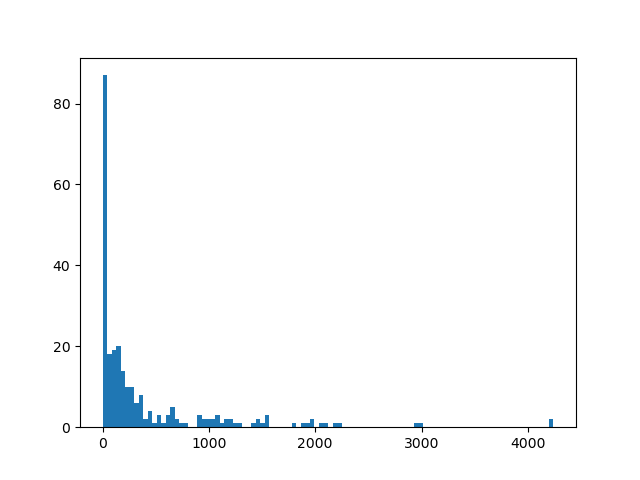

In [21]:
plt.figure()
amount_of_corners = np.array([len(a) for a in streetcorner_dict.values()])
_ = plt.hist(amount_of_corners, bins=100)
print(np.count_nonzero(amount_of_corners <= 10))

In [22]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf   = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [23]:
corner_dir = os.path.join(get_largest_subdirectory(os.path.join(proc_dir, "street_corners")), "pickles")

if os.path.isdir(os.path.join(proc_dir, "focus")):
    referencing_dir  =  os.path.join(proc_dir, "focus") + "\\"
    print(f"Focus found, using {referencing_dir}")

registration_dir = os.path.join(proc_dir, "registration")
os.makedirs(registration_dir, exist_ok=True)

descriptor_kwds = {
    # "angle_step"        : 18,
    "angle_step"        : 5,
    # "azimuth_radius"    : [50, 100, 500]
    "azimuth_radius"    : [50, 100, 250, 500]
}

print(corner_dir)

Focus found, using D:\RECTDNN\processing\2024-11-15_09-31-24\\focus\
D:\RECTDNN\processing\2024-11-15_09-31-24\\street_corners\exp1\pickles


In [24]:
"""
def iterativeAdjustFromMatching(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.04, logging_dir=None, filter_topn=None):

    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[a] for a in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    if len(matchresults[0]) > 4:
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
        toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))
    else:
        fromPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.y))).T
        toPoints = np.vstack((np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.x), np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.y))).T
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(fromPoints[:, 0], fromPoints[:, 1]))
        toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(toPoints[:, 0], toPoints[:, 1]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    coordsA, coordsB = normCoords(coordsA, coordsB)

    i = 0

    checker = True
    prev = np.where(idx)[0].shape[0]

    # if plot:
    #     plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)

    if logging_dir is not None:
        fig, axs, _, _ = plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()

    while checker:
        print(np.count_nonzero(prev), len(idx), np.where(idx)[0].shape[0] )
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False, )
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T


        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        idx = most_popular_indices_2d(test, eps=dbscan_eps)

        counter = 0
        if np.where(idx)[0].shape[0] < 5:
            print("Loosening, under 5... ", end=" ")
            while np.where(idx)[0].shape[0] < 5:
                counter = counter + 1
                idx = most_popular_indices_2d(test, eps=dbscan_eps + 0.02 * counter)
                if counter > 10:
                    break
            print(f"Loosened {counter} times at {dbscan_eps + 0.02 * counter}")
        
            

        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:
            print(i)
            print(np.linalg.inv(matrix).T)
            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Iteration {i}")
            fig.savefig(logging_dir[:-3] + f"internalremovals_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i = i + 1

    return matrix, distances

def registerImagesV1(ra, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, 
                     
                     r_initial=500, 
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     dbscan_ini=0.04,
                     logging_dir=None,
                     ):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, os.path.basename(ra.files[0]).split(".")[0])

    logging_struct = {}

    for i in range(n_iters):

        logging_struct[i] = {}
        
        r_current = r_initial * 0.95 ** i
        dbscan_curr = dbscan_ini + 0.05 * i
        if i == 0:
            # matching_results, im_corner_gdf, corners_curr = matching(im_corner_gdf, corners_curr, ratio_threshold=0.9, **descriptor_kwds)
            matching_results, im_corner_gdf, corners_curr = matching_distances_loosen_distance(im_corner_gdf, corners_curr, ratio_threshold=0.8, 
                                                                                               match_radius=r_initial, 
                                                                                               num_retries=10, 
                                                                                               loosening_factor=1, **descriptor_kwds)
            
            logging_struct[i]["matching_results"] = matching_results
            logging_struct[i]["im_corner_gdf"] = im_corner_gdf
            logging_struct[i]["corners_curr"] = corners_curr

            print(len(matching_results))
            if len(matching_results) < 3:
                raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
            
            matrix, distances = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, 
                                                            im_corner_gdf=im_corner_gdf, 
                                                            dbscan_eps=dbscan_curr, 
                                                            plot=verbose>3, 
                                                            verbose=verbose>8,
                                                            filter_topn=50,
                                                            logging_dir=None if logging_dir is None else logging_basename + "_iteration00.jpg"
                                                            )
        else:
            # matching_results, _, _ = matching_distances(im_corner_gdf_adj, corners_curr, match_radius=r_current, ratio_threshold=0.9, **descriptor_kwds)
            matching_results, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, ratio_threshold=0.8, 
                                                                        match_radius=r_current, 
                                                                        num_retries=10,
                                                                        loosening_factor=0.25, 
                                                                        **descriptor_kwds)
            
            ""
            Registration_initial
            matching_results, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, ratio_threshold=0.8, 
                                                                        match_radius=r_current, 
                                                                        num_retries=10, 
                                                                        loosening_factor=0.25, 
                                                                        **descriptor_kwds)
            ""

            # print(matching_results)
            if len(matching_results) < 3:
                raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
            
            matrix, distances = iterativeAdjustFromMatching(matching_results, plot=verbose>8, 
                                                            dbscan_eps=dbscan_curr,
                                                            verbose=verbose>8,
                                                            # filter_topn=100,
                                                            logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
            logging_struct[i]["matching_results"] = matching_results

        # compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 
        compoundedAdjustment = matrix @ compoundedAdjustment 

        rev_adj = compoundedAdjustment @ flip
        current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        scale = np.sqrt(0.5 * (matrix[0,0] ** 2 + matrix[1,1] ** 2))
        translation = np.sqrt(matrix[0,2] ** 2 + matrix[1,2] ** 2)
        conv_check = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if verbose > 5:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
            print(conv_check)
            print(rev_adj)

        if verbose > 10:
            plt.figure()
            plt.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1])
            test = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            plt.scatter(test[:, 0], test[:, 1])
            plt.show()

        im_corner_gdf_adj = im_corner_gdf.copy()
        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])

        # return im_corner_gdf_adj

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

        matched_check = np.nanpercentile(distances, 50) < distance_threshold # and distances.shape[0] > 10

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break
    print(logging_basename)
    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(logging_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return current_adjustment, im_corner_gdf_adj"""

'\ndef iterativeAdjustFromMatching(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.04, logging_dir=None, filter_topn=None):\n\n    if filter_topn is not None:\n        print(f"Filtering top {filter_topn}")\n        conf = [a[8][0] / a[8][1] for a in matchresults]\n        indices = np.argsort(conf)[:filter_topn]\n        matchresults = [matchresults[a] for a in indices]\n\n    if idx is None:\n        idx = np.arange(len(matchresults), dtype=np.int32)\n    \n    if len(matchresults[0]) > 4:\n        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))\n        toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))\n    else:\n        fromPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geomet

In [27]:
np.set_printoptions(precision=8) 

In [68]:
def normCoords(A, B):
    offsets = np.min(A, axis=0)
    return A - offsets, B - offsets

def updateResults(list1, list2, compare_idx=8):
    combined_dict = {}
    
    # Add elements from list1, prioritizing these tuples initially
    for tup in list1:
        key = (tup[0], tup[1])  # A and B are used as the key
        if key not in combined_dict:
            combined_dict[key] = tup
    
    # Add or update elements from list2
    for tup in list2:
        key = (tup[0], tup[1])  # A and B are used as the key
        # Replace the tuple if the key exists and G in list2's tuple is greater
        
        if key in combined_dict:
            print_val = combined_dict[key][compare_idx][0]
        else:
            print_val = None
        # print(key, key in combined_dict, tup[compare_idx][0], print_val)
        if key not in combined_dict:
            combined_dict[key] = tup
        elif key in combined_dict and tup[compare_idx][0] > combined_dict[key][compare_idx][0]:
            combined_dict[key] = tup
                
    # Convert the dictionary back to a list
    combined_list = list(combined_dict.values())

    print(len(list1), len(list2), len(combined_list))
    return combined_list

def adjustFromMatchingV2(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.04, logging_dir=None, filter_topn=None):

    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[a] for a in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
    toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    # coordsA, coordsB = normCoords(coordsA, coordsB)

    i = 0

    checker = True
    prev = np.where(idx)[0].shape[0]

    if logging_dir is not None:
        fig, axs, _, _ = plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()
    
    while checker and i < 5:
        
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False, )
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        idx = most_popular_indices_2d(test, eps=dbscan_eps)

        counter = 0
        if np.where(idx)[0].shape[0] < 5:
            print("Loosening, under 5... ", end=" ")
            while np.where(idx)[0].shape[0] < 5:
                counter = counter + 1
                idx = most_popular_indices_2d(test, eps=dbscan_eps + 0.02 * counter)
                if counter > 10:
                    break
            print(f"Loosened {counter} times at {dbscan_eps + 0.02 * counter}")
        
        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:
            print(i)
            print(np.linalg.inv(matrix).T)
            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Iteration {i}")
            fig.savefig(logging_dir[:-3] + f"internalremovals_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i = i + 1

    return matrix, distances

def registerImagesV2(ra, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     dbscan_ini=0.04,
                     logging_dir=None,
                     ):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, os.path.basename(ra.files[0]).split(".")[0])

    logging_struct = {}

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()

    for i in range(n_iters):

        logging_struct[i] = {}
        
        r_current = r_initial * 0.95 ** i
        dbscan_curr = dbscan_ini + 0.05 * i
            
        matching_results_curr, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, ratio_threshold=0.8, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            matching_results = updateResults(matching_results, matching_results_curr)
        
        if len(matching_results) < 3:
            raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
        
        matrix, distances = adjustFromMatchingV2(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        # filter_topn=100,
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        logging_struct[i]["matching_results"] = matching_results

        print(compoundedAdjustment)
        compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 
        # # compoundedAdjustment = compoundedAdjustment @ np.linalg.inv(matrix)
        # # compoundedAdjustment = compoundedAdjustment @ matrix

        # rev_adj = compoundedAdjustment @ flip
        # current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

        # current_adjustment = getMatrixFromAffine(ra.transform) @ np.linalg.inv(matrix)
        current_adjustment = np.linalg.inv(matrix) @ getMatrixFromAffine(ra.transform)

        """OLD
        # compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 
        compoundedAdjustment = matrix @ compoundedAdjustment 

        rev_adj = compoundedAdjustment @ flip
        current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj
        """

        print("Difference")
        print(current_adjustment)
        print(getMatrixFromAffine(ra.transform))
        print(getMatrixFromAffine(ra.transform) - current_adjustment)

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        scale = np.sqrt(0.5 * (matrix[0,0] ** 2 + matrix[1,1] ** 2))
        translation = np.sqrt(matrix[0,2] ** 2 + matrix[1,2] ** 2)
        conv_check = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if verbose > 5:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
            print(conv_check)
            print(np.linalg.inv(matrix))
            print("Inverse")
            print(np.linalg.inv(np.linalg.inv(matrix)))

        if verbose > 10:
            fig, ax  = plt.subplots()
            ax.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1], label="Reprojected Corners")

            original_image_corners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            ax.scatter(original_image_corners[:, 0], original_image_corners[:, 1], label="Original Image Corners")

            # READ MATCHING RESULTS AND GET DATABASE (TARGET?)
            db_corners_x = np.array([m[5][0] for m in matching_results])
            db_corners_y = np.array([m[5][1] for m in matching_results])
            ax.scatter(db_corners_x, db_corners_y, label="Matching - Image Corners")

            # READ MATCHING RESULTS AND GET DETECTIONS (REFERENCE?)
            r_corners_x = np.array([m[4][0] for m in matching_results])
            r_corners_y = np.array([m[4][1] for m in matching_results])
            ax.scatter(r_corners_x, r_corners_y, label="Matching - Database Corners")

            ax, _ = calcQuiver(ax, 
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(db_corners_x, db_corners_y)),
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(r_corners_x, r_corners_y)), )

            cx.add_basemap(ax, zoom_adjust=1)
            ax.legend()
            plt.show()

        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])

        # return im_corner_gdf_adj

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

        matched_check = np.nanpercentile(distances, 50) < distance_threshold # and distances.shape[0] > 10

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break
    print(logging_basename)
    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(logging_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return current_adjustment, im_corner_gdf_adj

1298 / 4645


  0%|          | 0/15693 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/15693 [00:00<?, ?it/s]

Error adding Basemap


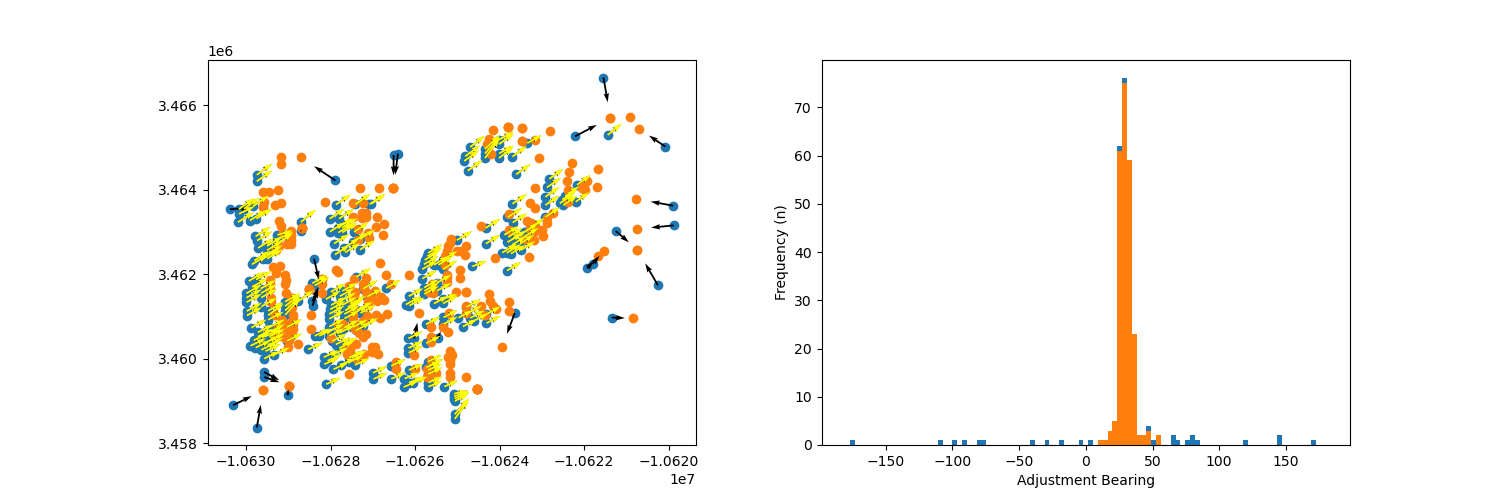

0
[[1.02815520e+00 6.67048213e-03 0.00000000e+00]
 [3.29542042e-03 9.95194739e-01 0.00000000e+00]
 [2.87269038e+05 8.72241214e+04 1.00000000e+00]]


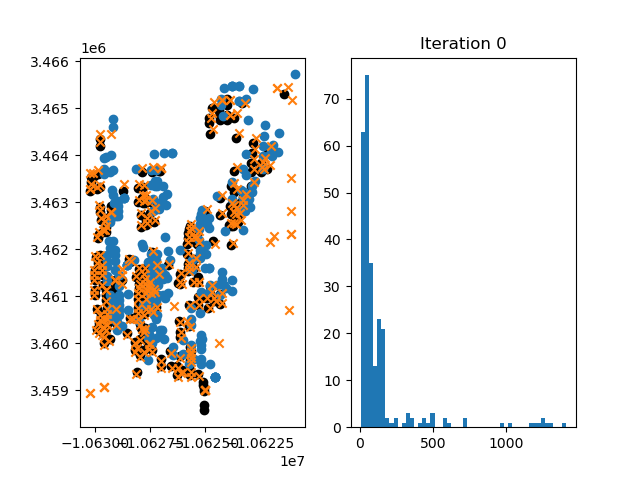

1
[[ 1.00773801e+00  2.89875834e-03  0.00000000e+00]
 [-4.34673654e-03  9.72936885e-01  0.00000000e+00]
 [ 9.67235450e+04  1.24177018e+05  1.00000000e+00]]


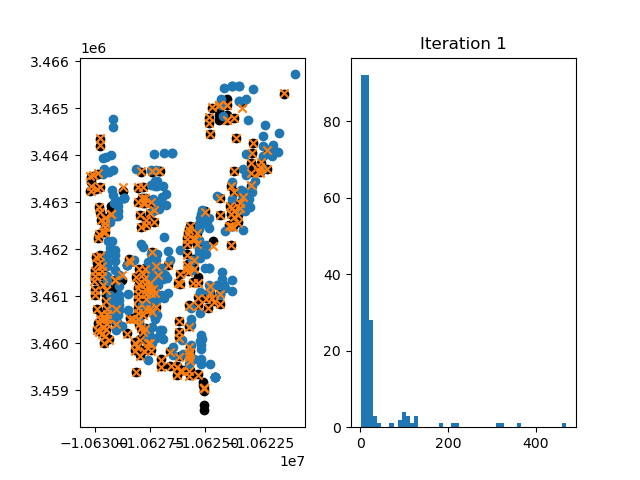

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Difference
[[ 2.37533215e+00  1.06657847e-02 -1.06308188e+07]
 [ 6.83264284e-03 -2.38733939e+00  3.46538953e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.35709295e+00  1.05915277e-13 -1.06302206e+07]
 [ 1.56874513e-13 -2.45374538e+00  3.46582292e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.82391999e-02 -1.06657847e-02  5.98187172e+02]
 [-6.83264284e-03 -6.64059935e-02  4.33386943e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Scale 1.010e+00
Translation 1.598e+05
False
[[ 1.00773801e+00 -4.34673654e-03  9.67235450e+04]
 [ 2.89875834e-03  9.72936885e-01  1.24177018e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.92308658e-01  4.43328275e-03 -9.65301230e+04]
 [-2.95647440e-03  1.02780269e+00 -1.27343513e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


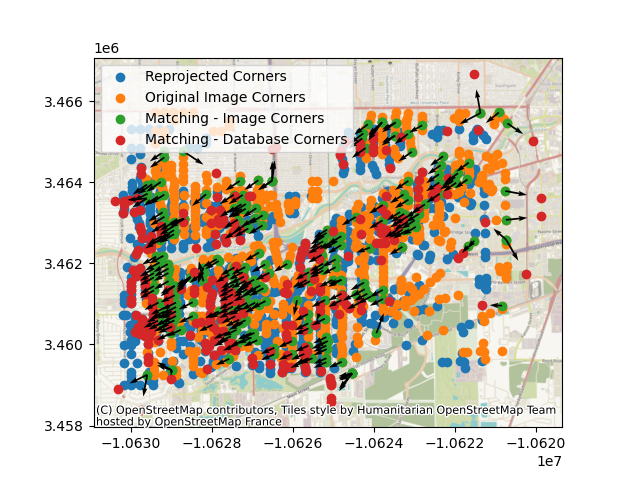

[  0.97270246   8.16398079  12.19008169  18.94431888 468.74973183] 263


  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/15693 [00:00<?, ?it/s]

263 284 372
Error adding Basemap


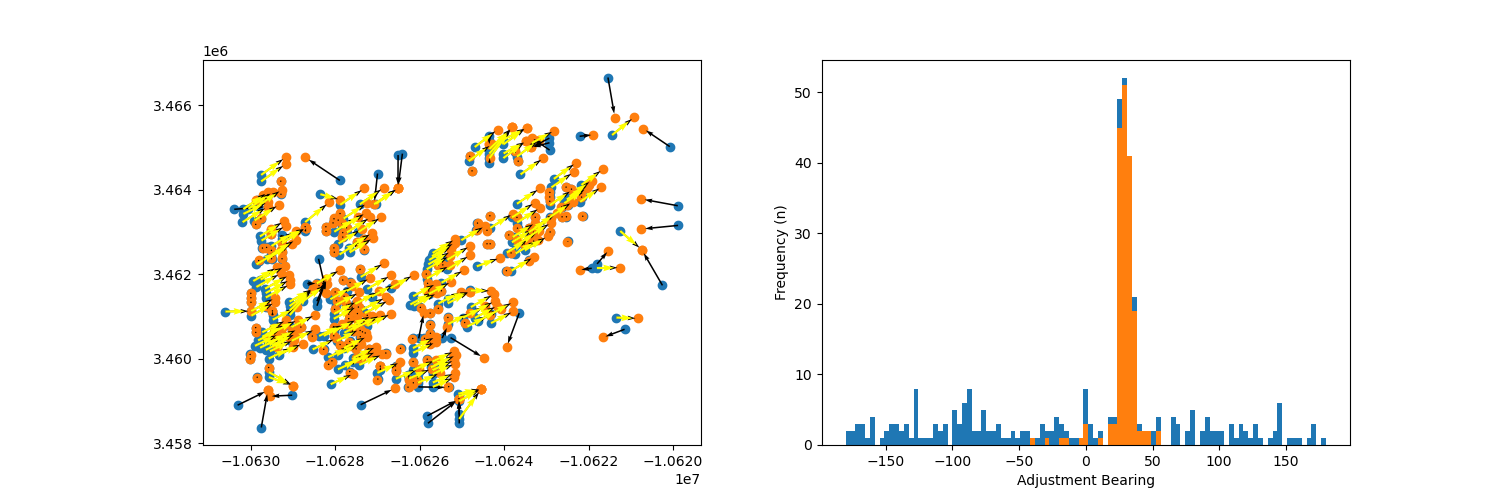

0
[[1.01924055e+00 3.27043668e-03 0.00000000e+00]
 [1.24530208e-02 1.00618611e+00 0.00000000e+00]
 [1.61077975e+05 1.31869230e+04 1.00000000e+00]]


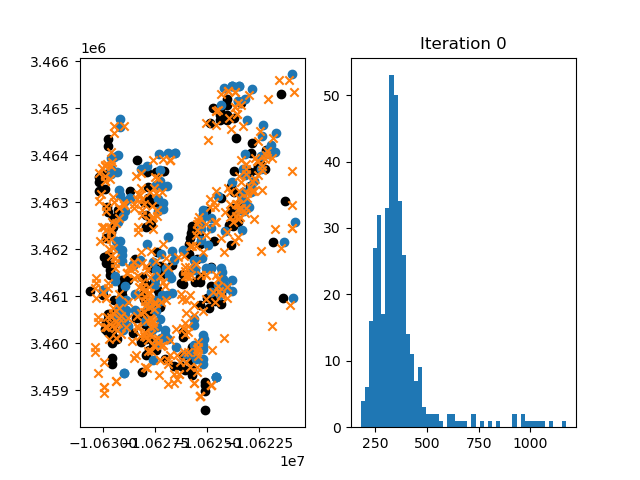

1
[[ 1.00750709e+00  7.71660406e-03  0.00000000e+00]
 [-3.46772771e-03  9.67228053e-01  0.00000000e+00]
 [ 9.12269590e+04  1.95155884e+05  1.00000000e+00]]


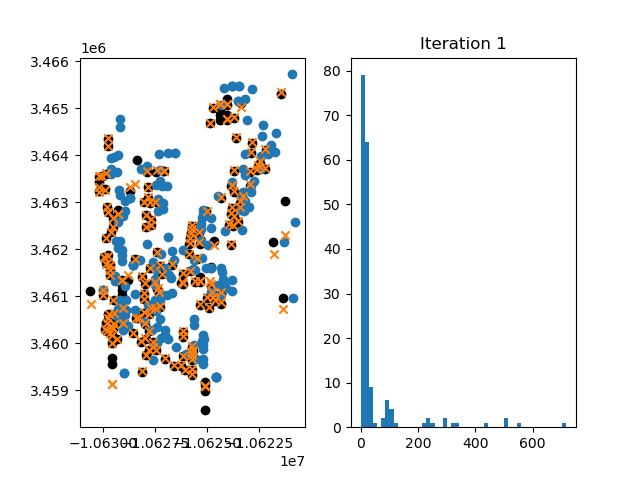

[[ 1.00773801e+00 -4.34673654e-03  9.67235450e+04]
 [ 2.89875834e-03  9.72936885e-01  1.24177018e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Difference
[[ 2.37478786e+00  8.50892085e-03 -1.06308142e+07]
 [ 1.81887530e-02 -2.37333137e+00  3.46536784e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.35709295e+00  1.05915277e-13 -1.06302206e+07]
 [ 1.56874513e-13 -2.45374538e+00  3.46582292e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.76949051e-02 -8.50892085e-03  5.93576987e+02]
 [-1.81887530e-02 -8.04140123e-02  4.55083337e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Scale 1.013e+00
Translation 2.208e+05
False
[[ 1.00750709e+00 -3.46772771e-03  9.12269590e+04]
 [ 7.71660406e-03  9.67228053e-01  1.95155884e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.92521594e-01  3.55841068e-03 -9.12391715e+04]
 [-7.91839745e-03  1.03385395e+00 -2.01040309e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


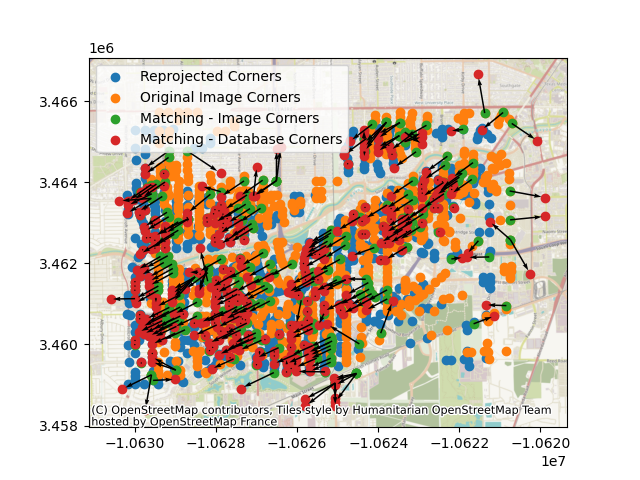

[4.97358300e-01 8.67514463e+00 1.70265525e+01 2.64136555e+01 7.15967646e+02] 372
D:\RECTDNN\processing\2024-11-15_09-31-24\\registration/logs/4802960155B


  0%|          | 0/100 [00:00<?, ?it/s]

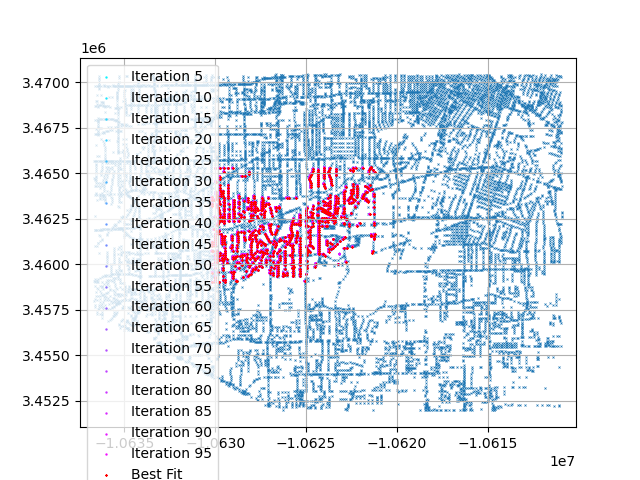

NameError: name 'error' is not defined

In [70]:
register_tile_names = glob.glob(referencing_dir + "*")

flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 
    

for tile_dir in register_tile_names:

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.2]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        print(f"{len(corner_bbox)} / {len(x)}")

    image = cv2.imread(tile_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ra_ref = rio.open(tile_dir)
    corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
    corner_arry = cleanCenterBBOX(corner_arry, bbox)

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])

    bounds_poly = enlarged_bounds(ra_ref, n=2)
    corners_curr = gpd.clip(corners, bounds_poly)

    prev_transform = getMatrixFromAffine(ra_ref.transform)

    current_adjustment_mymethod, im_corner_gdf_adj = registerImagesV2(ra_ref, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds,
                                        distance_threshold=5,
                                        n_iters=2,
                                        r_initial=1000, 
                                        verbose=1000, logging_dir=f"{registration_dir}/logs/")

    try:
        with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                    driver='GTiff', count=1, dtype=np.uint8,
                    height=image.shape[0], width=image.shape[1],
                    crs=f'EPSG:3857',
                    # compress= 'CCITTFAX4',  # Use CCITTFAX4 or CCITTRLE for binary data compression
                    transform=rio.Affine(*current_adjustment_mymethod.flatten()[:6])) as dst:
                        dst.write(image, 1) 
    except Exception as e:
        print(e)
        traceback.print_exc()

    # current_adjustment = current_adjustment_mymethod @ best_transform

    icp_transform, transform_dict = performWeightedICPonTile([im_corner_gdf_adj], [corners_curr], proc_limit=5000, 
                                                          icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
                                                          plot=True, shear=True, dist_threshold=100)
    
    # rev_adj = np.linalg.inv(icp_transform) @ flip
    # rev_adj = icp_transform @ flip
    # current_adjustment = current_adjustment_mymethod @ flip @ rev_adj
    current_adjustment = icp_transform @ current_adjustment_mymethod

    try:
        with rio.open(f"{registration_dir}/{tile_name}_icp.tif", 'w',
                    driver='GTiff', count=1, dtype=np.uint8,
                    height=image.shape[0], width=image.shape[1],
                    crs=f'EPSG:3857',
                    # compress= 'CCITTFAX4',  # Use CCITTFAX4 or CCITTRLE for binary data compression
                    transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                        dst.write(image, 1) 
    except Exception as e:
            print(e)
            traceback.print_exc()

    error
    
    ra_ref.close()

In [ ]:
out_dict['4802960155C'][0]['im_corner_gdf']

geometry  descriptors0  descriptors1  \
0   POINT (-10628289.544 3463368.449)           1.0           2.0   
0   POINT (-10626888.116 3460540.742)           1.0           2.0   
0   POINT (-10624815.861 3459442.898)           1.0           2.0   
0   POINT (-10628794.324 3461530.907)           1.0           2.0   
0   POINT (-10624158.318 3462572.571)           1.0           2.0   
..                                ...           ...           ...   
0   POINT (-10622863.159 3461282.781)           1.0           2.0   
0   POINT (-10628510.939 3460433.064)           1.0           2.0   
0   POINT (-10627477.026 3460098.327)           1.0           2.0   
0   POINT (-10626996.599 3460084.282)           1.0           2.0   
0   POINT (-10623020.349 3462476.598)           1.0           2.0   

    descriptors2  descriptors3  descriptors4  descriptors5  descriptors6  \
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
..           ...           ...           ...           ...           ...   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   
0            2.0           2.0           2.0           2.0           2.0   

    descriptors7  descriptors8  ...  descriptors278  descriptors279  \
0            2.0           2.0  ...        0.276948        0.324417   
0            2.0           2.0  ...        2.000000        2.000000   
0            2.0           2.0  ...        2.000000        2.000000   
0            2.0           2.0  ...        2.000000        0.147140   
0            2.0           2.0  ...        2.000000        0.095781   
..           ...           ...  ...             ...             ...   
0            2.0           2.0  ...        2.000000        2.000000   
0            2.0           2.0  ...        0.663953        2.000000   
0            2.0           2.0  ...        0.297971        2.000000   
0            2.0           2.0  ...        2.000000        0.378626   
0            2.0           2.0  ...        2.000000        2.000000   

    descriptors280  descriptors281  descriptors282  descriptors283  \
0         2.000000        0.413840        2.000000        0.451516   
0         2.000000        2.000000        0.155086        0.397210   
0         2.000000        2.000000        2.000000        2.000000   
0         2.000000        0.278595        2.000000        2.000000   
0         0.185655        2.000000        2.000000        0.265473   
..             ...             ...             ...             ...   
0         0.388528        0.681590        2.000000        0.413307   
0         0.467339        0.180975        2.000000        2.000000   
0         2.000000        2.000000        0.254330        2.000000   
0         2.000000        2.000000        2.000000        0.369505   
0         0.481704        2.000000        0.288354        2.000000   

    descriptors284  descriptors285  descriptors286  descriptors287  
0         2.000000        0.029047        0.033986        0.504750  
0         2.000000        2.000000        2.000000        0.280835  
0         2.000000        0.328521        2.000000        2.000000  
0         2.000000        0.389957        2.000000        2.000000  
0         2.000000        2.000000        2.000000        2.000000  
..             ...             ...             ...             ...  
0         2.000000        2.000000        0.842499        0.016509  
0         0.023320        2.000000       

<Axes: >

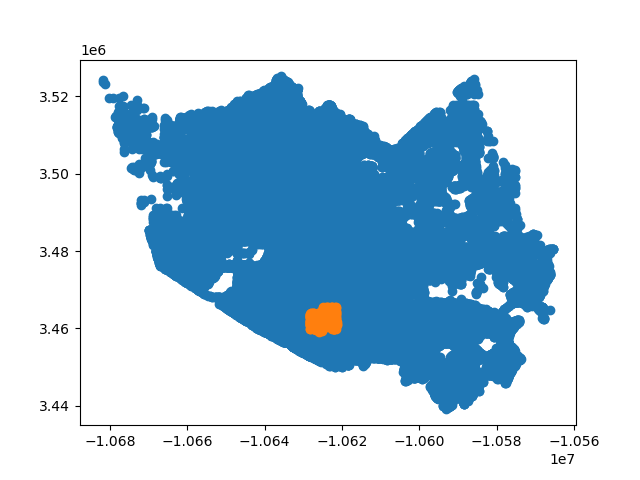

In [ ]:
fig, ax = plt.subplots()

corners.plot(ax=ax)
im_corner_gdf_adj.plot(ax=ax)

In [ ]:
logs_tile_names = glob.glob(registration_dir + "/logs/*.pkl")
out_dict = {}

for tile_name in logs_tile_names:
    with open(tile_name, 'rb') as handle:
        # pickle.dump(logging_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)     
        try:
            out_dict[os.path.basename(tile_name).split(".")[0]] = pickle.load(handle)
        except:
            print("Error " + tile_name)


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

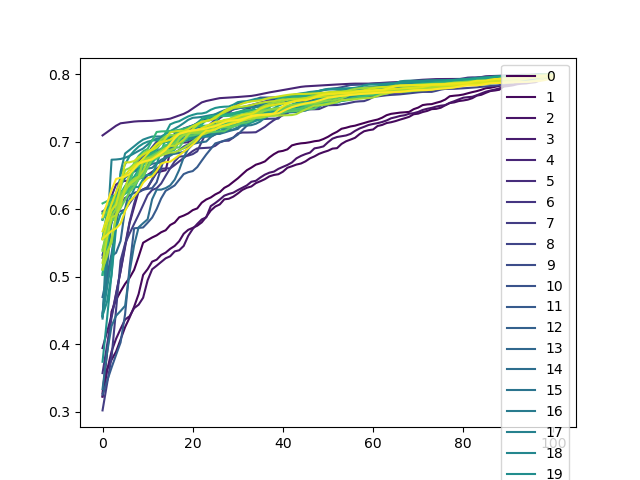

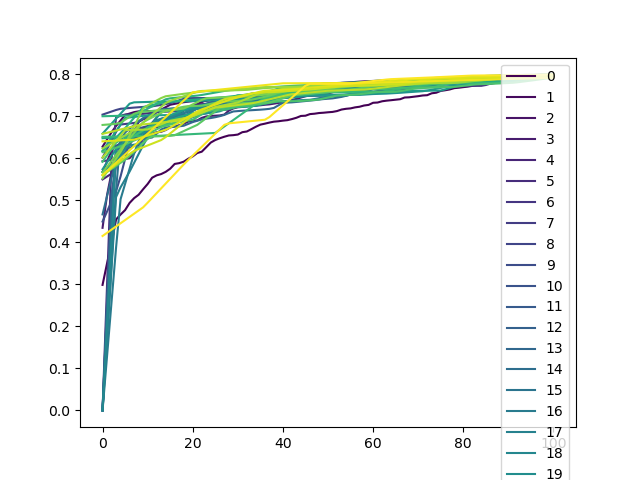

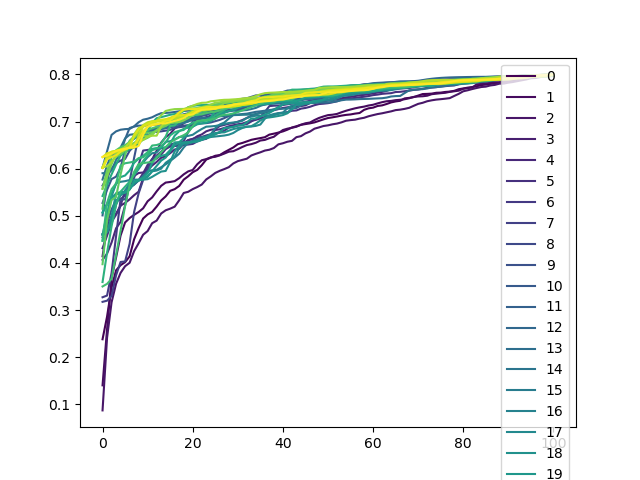

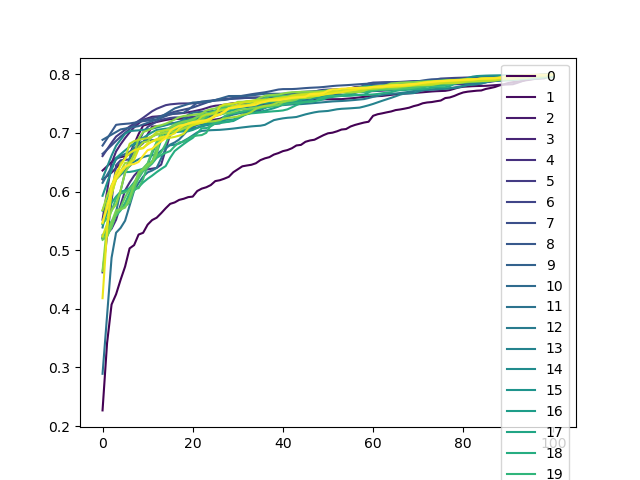

In [ ]:
for k, v in out_dict.items():
    fig, ax = plt.subplots(1, 1)

    cmap = cm.viridis  # Choose a colormap
    norm = mcolors.Normalize(vmin=0, vmax=len(v) - 1)

    for i, (kk, vv) in enumerate(v.items()):
        pops = [a[7].shape[0]for a in vv['matching_results']]
        conf = [a[8][0] / a[8][1] for a in vv['matching_results']]

        color = cmap(norm(i))  # Get color from colormap

        ax.plot(np.nanpercentile(conf, np.arange(0, 101)), color=color, label=f"{i}")


        # fig, axs = plt.subplots(1, 2)
        # axs[0].set_title(f"Radius: {500 * 0.95 ** i:.2f}")
        # axs[0].hist(pops, bins=20, range=(0, 40))
        # axs[1].hist(conf, bins=20, range=(0, 0.8))
        # plt.show()
    ax.legend()

In [ ]:
def assign_and_output_rasters(selected_rasters, source_folder, output_folder):
    """
    Outputs all rasters to a specified folder, updating their projection information
    if they share the same base code as the selected rasters.
    
    Parameters:
        selected_rasters (list): List of file paths to the selected rasters.
        source_folder (str): Path to the folder containing the source rasters.
        output_folder (str): Path to the folder where updated rasters will be saved.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Extract base codes and their respective affine/projection info from selected rasters
    code_to_transform = {}
    
    for raster_path in selected_rasters:
        base_code = os.path.basename(raster_path).split(".")[0][:-1]  # Remove the suffix (last character)
        
        # Read the affine transform and CRS (projection info)
        with rio.open(raster_path) as src:
            code_to_transform[base_code] = {
                "transform": src.transform,
                "crs": src.crs
            }
    
    # Iterate through all rasters in the source folder
    for raster_file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, raster_file)
        
        # Skip if not a valid raster file
        if not raster_file.endswith(('.tif', '.img', '.jp2')):  # Add more extensions if needed
            continue
        
        base_code = os.path.basename(raster_file).split(".")[0][:-1]  # Extract base code
        
        # Determine the output path
        output_path = os.path.join(output_folder, raster_file)
        
        # If the raster matches a selected base code, update its projection info
        if base_code in code_to_transform:
            with rio.open(source_path) as src:
                data = src.read()  # Read all raster data
            
            # Write the raster with updated projection information
            with rio.open(
                output_path, 
                "w",
                driver=src.driver,
                height=src.height,
                width=src.width,
                count=src.count,
                dtype=src.dtypes[0],
                transform=code_to_transform[base_code]["transform"],
                crs=code_to_transform[base_code]["crs"]
            ) as dst:
                dst.write(data)
            
            print(f"Output and updated projection: {raster_file} -> {output_path}")
        else:
            # Copy the file as-is to the output folder
            with rio.open(source_path) as src:
                data = src.read()
                with rio.open(
                    output_path,
                    "w",
                    driver=src.driver,
                    height=src.height,
                    width=src.width,
                    count=src.count,
                    dtype=src.dtypes[0],
                    transform=src.transform,
                    crs=src.crs
                ) as dst:
                    dst.write(data)
            
            print(f"Output without modification: {raster_file} -> {output_path}")

In [ ]:
source_folder = r"D:\RECTDNN\processing\2024-11-15_09-31-24\registration\\"

# Example usage
"""selected_rasters = [
    f"{source_folder}4802960160C.tif",
    f"{source_folder}4802960155E.tif",
    f"{source_folder}4802960175D.tif"

]"""

"""selected_rasters = [
    f"{source_folder}4802960150D.tif",
    f"{source_folder}4802960080D.tif",
    f"{source_folder}4802960090B.tif"

]"""

selected_rasters = [
    f"{source_folder}4802960085D.tif",
    f"{source_folder}4802960115D.tif",
    f"{source_folder}4802960120C.tif",
    f"{source_folder}4802960125B.tif"

]

output_folder = r"D:\RECTDNN\processing\2024-11-15_09-31-24\registration_homo\\"

assign_and_output_rasters(selected_rasters, source_folder, output_folder)

12/09/2024 09:20:16 - INFO - rasterio._env -   GDAL signalled an error: err_no=4, msg='D:/RECTDNN/processing/2024-11-15_09-31-24/registration/4802960085D.tif: No such file or directory'


RasterioIOError: D:/RECTDNN/processing/2024-11-15_09-31-24/registration/4802960085D.tif: No such file or directory

In [ ]:
def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis


def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

bad = 0
RLNN = None

tile_coords = {}
debug_struct = {}

referencing_dir = os.path.join(proc_dir, "referencing")
os.makedirs(referencing_dir, exist_ok=True)

detected_tiles['reference_name'] = detected_tiles.index
list_tiles = list(detected_tiles_gdf.index)

# THERE'S AN ISSUE WITH PERFECT MATCHES ON SHORTER STRINGS. 
# (IE 48035 PERFECT FOR 48035001A, WHEN WE'RE LOOKING FOR 48035001)
# TO DEAL WITH IT, WE ONLY COMPARE AGAINST STRINGS OF A CERTAIN LENGTH 
# (SEE HEURISTICALLY-DETERMINED COMP_LENGTH BELOW)
# THIS STRUCTURE CONTAINS ALL POSSIBLE LENGTHS NEEDED, 
# SAVING APPROX 33% TIME INSTEAD OF DYNAMICALLY SHORTENING ALL STRINGS
curr_tile_name_length_dict = {}
bn_lengths = np.array([len(a) for a in tiles_bns])              # LENGTH OF BASENAMES FOR ALL TILES BEING USED
for i in range(np.min(bn_lengths) - 3, np.max(bn_lengths+3)):   # FOR A RANGE AROUND THAT BASE LENGTH
    curr_tile_name_length_dict[i] = [a if i <= len(a) else "" for a in list_tiles]

for i, tile in tqdm(enumerate(tiles), total=len(tiles)):

    comp_length = len(tiles_bns[i]) - 2

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", os.path.basename(tile))

    # PERFORM MATCHING
    match, score = process.extractOne(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    matches = process.extract(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    out_fn = os.path.join(referencing_dir, tiles_bns[i] + ".tif")
    
    if score >= 90:
        image = np.asarray(Image.open(tile))

        # IF IMAGE IS NOT UINT8, CONVERT
        if np.max(image) < 255:
            image = image * 255
            image = image.astype(np.uint8)

        tile_coords[out_fn] = detected_tiles.loc[match]
        tile_coords[out_fn]['input_file'] = tile

        bounds, RLNN = findBounds(tile, RLNN)
        
        if len(bounds[0]) < 1:
            print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile}")
            
            bbox = [0, 0, image.shape[0], image.shape[1]]
        else:
            bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        
        real_x, real_y = bbox_to_coords_realworld(tile_coords[out_fn]["coords"])
        pic_x, pic_y   = bbox_to_coords_raster(bbox)

        affine = affineTransformation(pic_x, pic_y, real_x, real_y)
        transform = bboxTransformToCRS(affine.matrix, image)

        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches, "bbox" : bbox,
            "real_x" : real_x, "real_y" : real_y,
            "pic_x"  : pic_x,  "pic_y"  : pic_y,
            "affine" : affine, "transform" : transform
        }
        try:
            with rio.open(out_fn, 'w',
                driver='GTiff', count=1, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
        except: 
            print(f"Could not save {tiles_bns[i]}")
                
    else:
        tile_coords[out_fn] = None
        print(f"Skipping {out_fn}")
        print(matches)
        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches,
        }
        bad = bad + 1

  0%|          | 0/599 [00:00<?, ?it/s]

Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_2.tif
[('480287_1', 82), ('4802870_1', 78), ('4802870', 75), ('4802870325', 74), ('4802870200', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_45.tif
[('4802870425', 80), ('4802870450', 80), ('4802870475', 80), ('4802870145', 80), ('4802870465', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_25.tif
[('4802870325', 80), ('4802870425', 80), ('4802870525', 80), ('4802870250', 80), ('4802870225', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_34.tif
[('4802870345', 80), ('4802870340', 80), ('48028703', 78), ('480287_1', 78), ('4802870_1', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_53.tif
[('4802870530', 80), ('48028703', 78), ('480287_1', 78), ('48028705360', 76), ('480287165', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_16.tif
[('480287_1', 89), ('480287165', 84),

  0%|          | 0/300 [00:00<?, ?it/s]

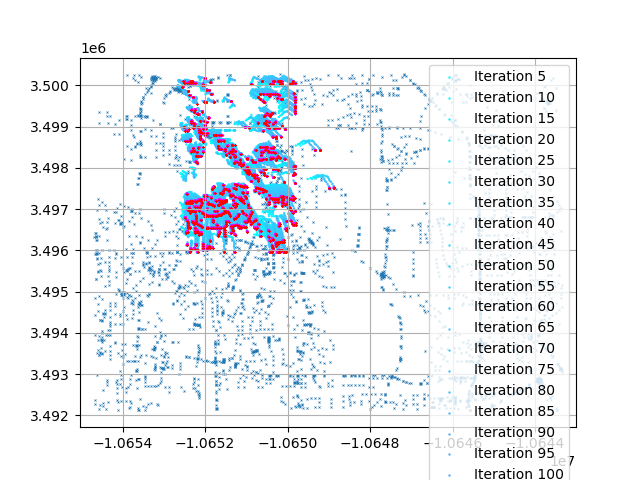

10/17/2024 16:55:43 - INFO - rasterio._env -   GDAL signalled an error: err_no=1, msg='Deleting D:/RECTDNN/processing/2024-10-11_15-08-46/48201C0420M_registered6.tif failed:\nPermission denied'


Could not save photo D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\48201C0420M.tif


  0%|          | 0/300 [00:00<?, ?it/s]

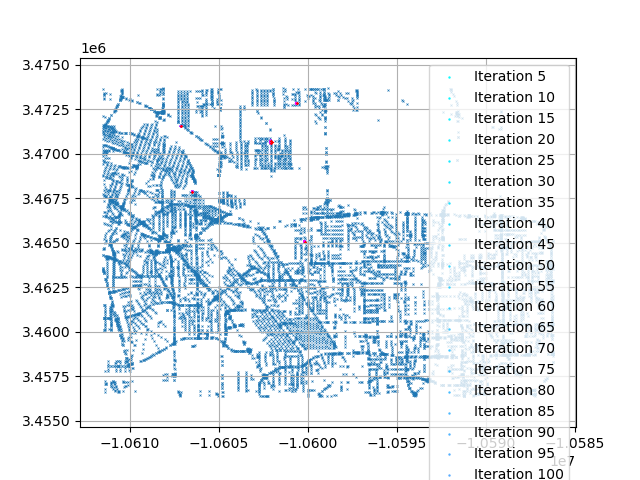

  0%|          | 0/300 [00:00<?, ?it/s]

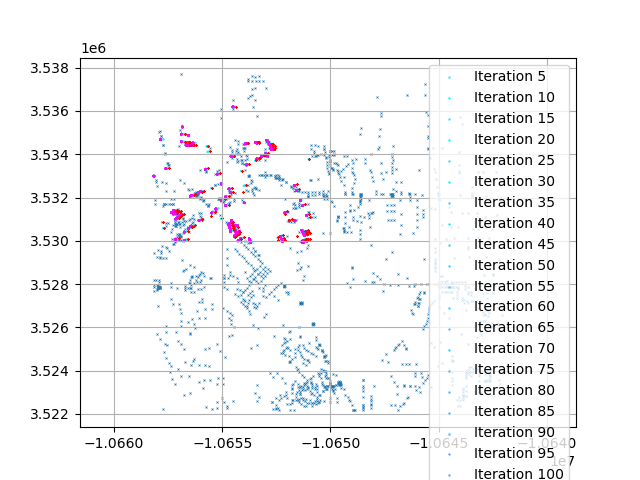

  0%|          | 0/300 [00:00<?, ?it/s]

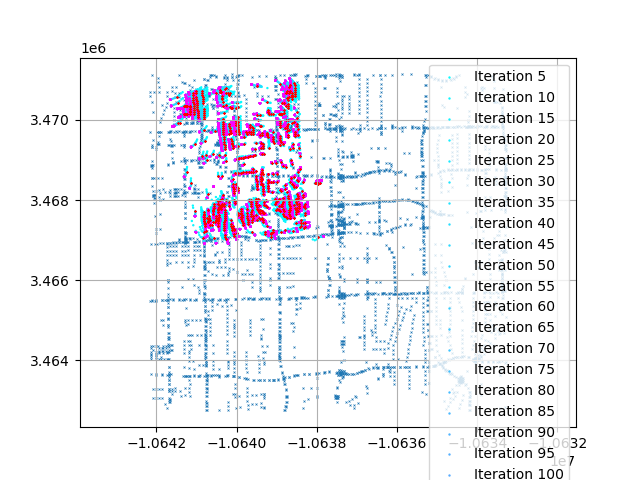

  0%|          | 0/300 [00:00<?, ?it/s]

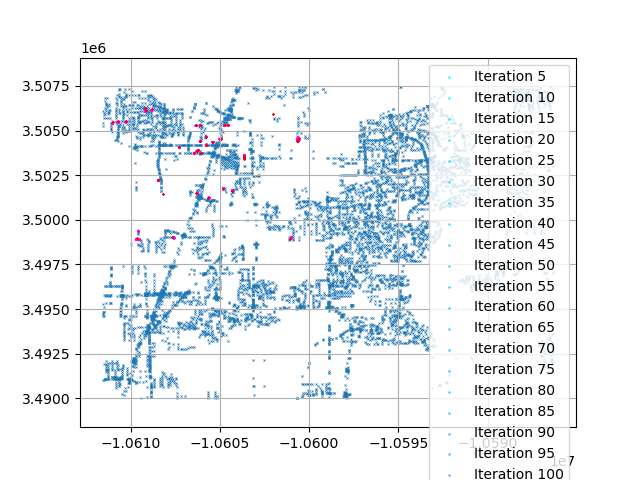

  0%|          | 0/300 [00:00<?, ?it/s]

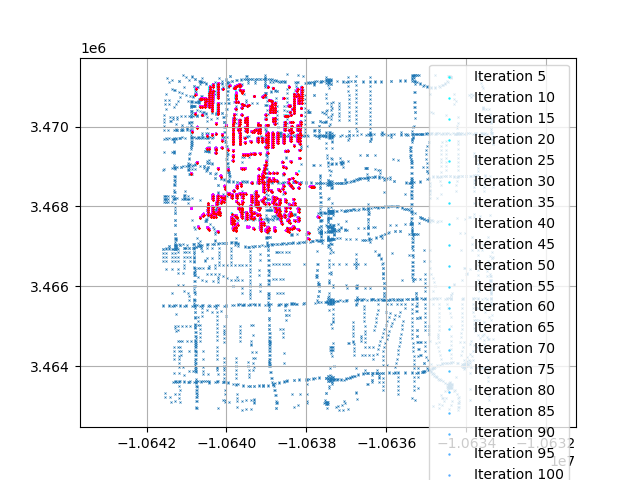

  0%|          | 0/300 [00:00<?, ?it/s]

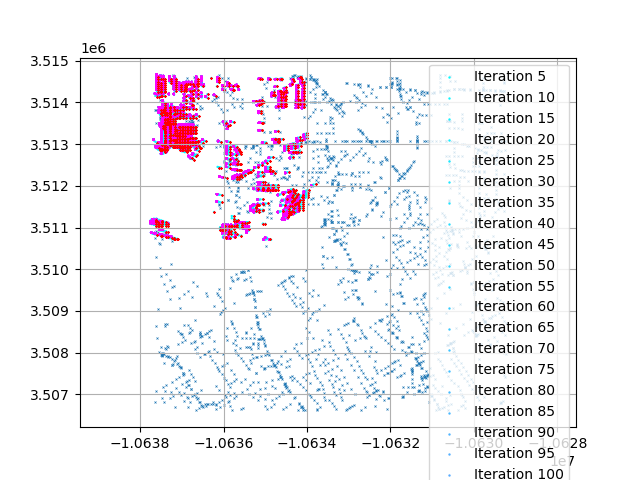

  0%|          | 0/300 [00:00<?, ?it/s]

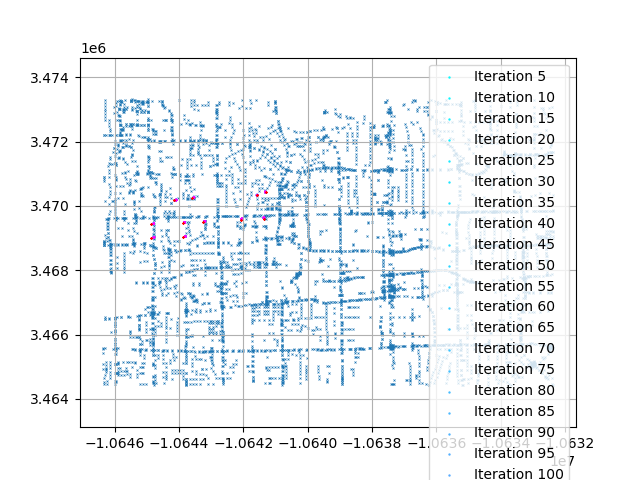

  0%|          | 0/300 [00:00<?, ?it/s]

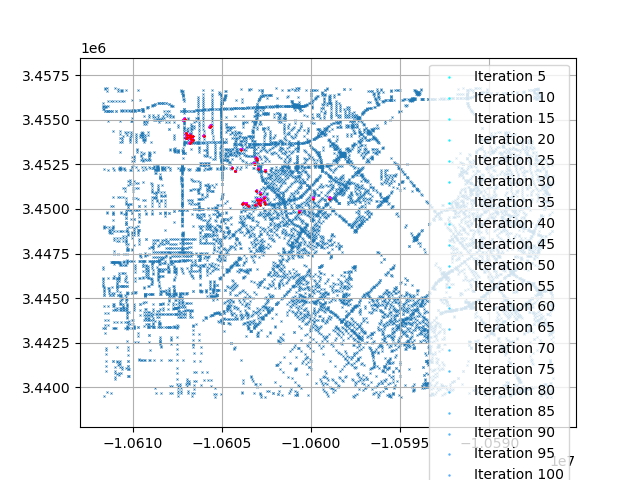

  0%|          | 0/300 [00:00<?, ?it/s]

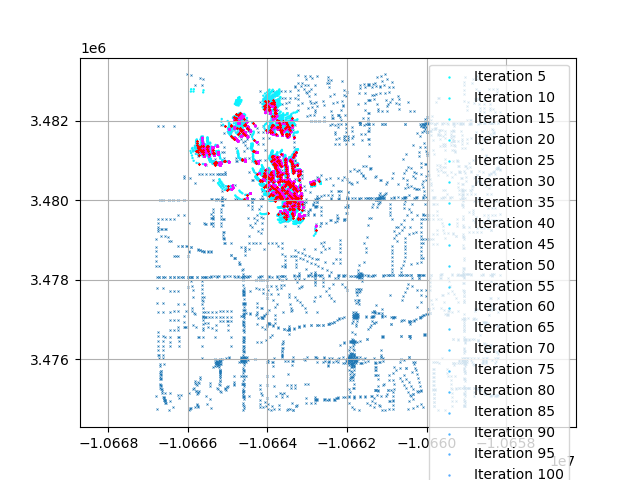

  0%|          | 0/300 [00:00<?, ?it/s]

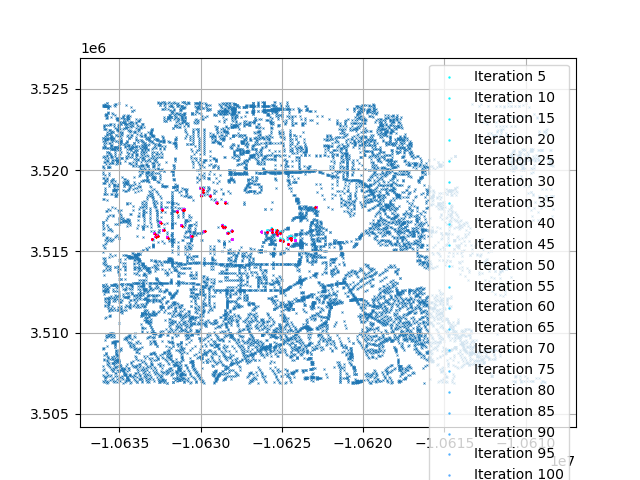

  0%|          | 0/300 [00:00<?, ?it/s]

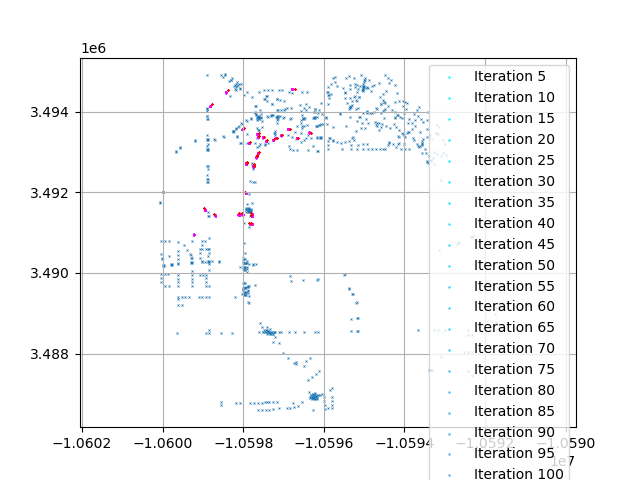

  0%|          | 0/300 [00:00<?, ?it/s]

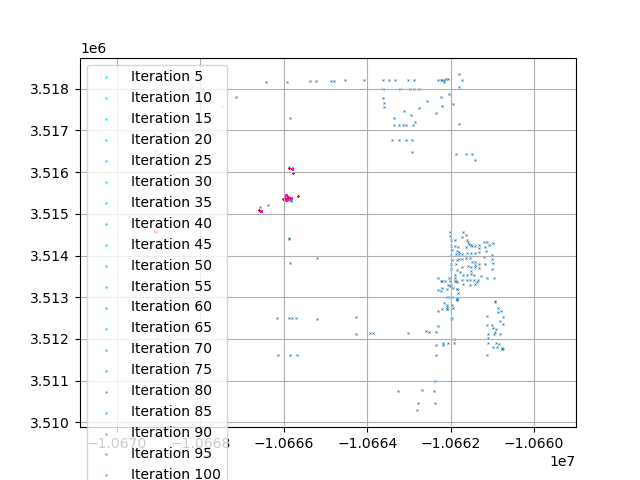

  0%|          | 0/300 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
bestgrades = []
numcorners = []

allgrades = []

model = TPNN(num_classes=2, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/FANN/checkpoint_101123.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:

        # try:
        
            # OPEN RASTER AND GET BOUNDING BOX
            ra = rio.open(out_name)
            bounds  = ra.bounds
            image   = ra.read(1)

            # VALID BBOX FOR OBSERVATIONS OF ROADS
            bbox = debug_struct[out_name]['bbox']

            '''
            # RUN ROADS DETECTION ON CNN AND PREP FOR ICP
            roads, _    = split_and_run_cnn(image, model, tilesize=1024, num_dim=3, edges=10, dims_rep=[0], n_pyramids=2, device="cuda", verbose=True)
            roads_thin  = roads[:, :, 1] > 0.95
            roads_thin  = cleanImageBBOX(roads_thin, bbox)
            roads_thin  = skeletonize(roads_thin)    # USE SKELETONIZATION ALGORITHM TO THIN ROADS
            y, x        = np.where(roads_thin[:, :])            # GET X, Y COORDINATES OF IDENTIFIED ROAD POINTS
            street_det  = pointsToGeodataFrame(ra, y, x)        # CONVERT X, Y COORDINATES TO GDF AND REPROEJCT TO CURRENT ESTIMATE OF RASTER POSITION

            # USING CURRENT ENLARGED RASTER EXTENTS, GET RELEVANT ROADS FROM OPENSTREETMAP FILE
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            roads_clipped = gpd.clip(roads_gdf, bounds_poly)    # CLIP
            streets = getRoadPoints(roads_clipped, 0.5)         # ROAD POINTS ALONG STREETS, 0.5 IN M
            '''

            # RUN YOLO DETECTION ON STREET INTERSECTIONS AND PREP FOR DATASET
            # corner_bbox = [street_corners[a]['bbox'] for a in street_corners]
            # corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) 
            # GET STREET CORNERS FROM TPNN OUTPUTS
            corner_arry = streetcorner_dict[os.path.basename(out_name).split(".")[0] + ".pickle"]# streetresults_struct[tile_coords[out_name]['input_file']]
            corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
            corner_arry = cleanCenterBBOX(corner_arry, bbox)

            # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
            corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])
            
            # GET SHAPEFILE OF STREET INTERSECTIONS
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            corners = gpd.clip(intersections, bounds_poly)
            
            # DEFINE OUTPUT FILENAME
            ICP_fn = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_ICP.tif")
            
            # ACTUALLY PERFORM ICP AND SAVE OUTPUT GRADE
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, save_fig=ICP_fn, icp_iterations=500, conv=1e-6)
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, icp_iterations=50, conv=1e-6, rotation_limit=20)
            # out = performWeightedICPonTile([street_det, corner_gdf], [streets, corners], weights=[1, 1/50])
            # best_transform, transform_dict = performWeightedICPonTile([street_det, corner_gdf], [streets, corners],proc_limit=200, icp_iterations=90, plot_datasets=[roads_clipped, corners], weights=[1, 1/10], plot=False, shear=True )
            best_transform, transform_dict = performWeightedICPonTile([corner_gdf], [corners], proc_limit=5000, icp_iterations=300, plot_datasets=[corners], weights=[1, 1/10], plot=True, shear=True, dist_threshold=1000, )
            
            bestgrades.append(np.min(transform_dict['grades']))

            # SAVE WITH REGISTRATION
            raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered6.tif")
            transform = best_transform @ getMatrixFromAffine(ra.transform) 
            
            # SAVE POINTS USED FOR ESTIMATION
            shp_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_XY.gpkg")
            a = gpd.GeoDataFrame(crs="EPSG:3857", geometry=gpd.points_from_xy(transform_dict['reproj'][0][:, 0], transform_dict['reproj'][0][:, 1]))
            a.to_file(shp_name)

            # SAVE ANCILLARY FILES
            out_struct = {
                "best_transform" : best_transform,
                "transform_dict" : transform_dict,
            }

            allgrades.append(transform_dict)
            
            try:
                with rio.open(raster_name, 'w',
                    driver='GTiff', count=1, dtype=np.uint8,
                    height=image.shape[0], width=image.shape[1],
                    crs=f'EPSG:3857',
                    transform=rio.Affine(*transform.flatten()[:6])) as dst:
                        dst.write(image, 1) 
                        # dst.write(roads_thin * 255, 2) 
                        # dst.write(draw_bounding_boxes(corner_bbox, image.shape[:2]), 3) 

                with open(raster_name[:-4] + ".pkl", 'wb') as handle:
                    pickle.dump(out_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)

            except:
                print(f"Could not save photo {out_name}")
        #except:
        #    print(f"Error with {out_name}")
        #    continue

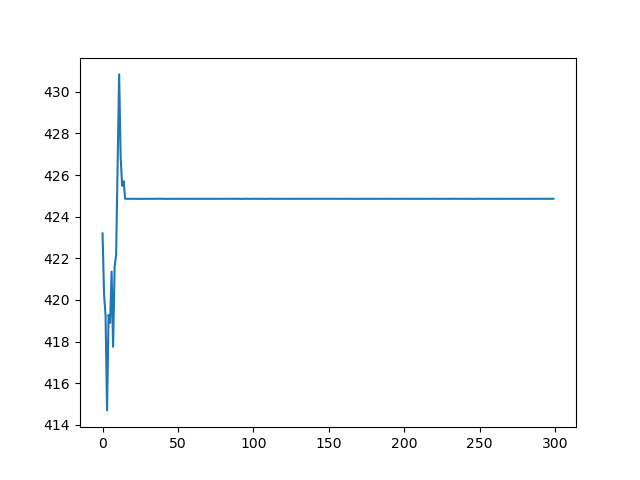

In [ ]:
plt.figure()
plt.plot(out_struct['transform_dict']['grades'])

In [ ]:
image.dtype

dtype('uint8')

In [ ]:
'''FANN_prior = None
RLNN_prior = None
model = None

color=False

plot_params = {"labels" : False, }
YOLO_params = {
    "device"  : "cuda",     "find_text" : False, 
    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,
    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True
}

# IF WE'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT
if os.path.exists(f'{proc_dir}results.pkl'):
    print("FOUND DICTIONARY, LOADING")
    with open(f'{proc_dir}results.pkl', 'rb') as handle:
        results_struct = pickle.load(handle)
else:
    results_struct = {}

# LOOP FOR EACH TILE
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):
    
    # DEFINE WHERE GEOREFERENCED TILE IS SAVED
    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")
    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")

    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP
    if results_struct.get(tile, None):
        # print(f"Found in dict, skipping {tile}")
        continue

    # WHICH VERSION OF FANN ARE WE USING
    if color:
        # RUN AND SAVE PREPROCESSING FANN AND RLNN
        prepped_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_prepped.png")                      # FILE NAME
        prepped, FANN_prior, RLNN_prior, bounds = findStreetCorners_colorPrep(tile, FANN=FANN_prior, RLNN=RLNN_prior)   # RUN FANN_PRIOR AND RLNN
        Image.fromarray(prepped).save(prepped_fn) # SAVE

        # RUN FANN
        results, model, base = runYOLO_Text(prepped_fn, model=model, model_weights=f"{data_dir}FANN/YOLO/051624.pt", **YOLO_params)
        
    else:
        bounds = None

        # RUN FANN
        results, model, base = runYOLO_Text(tile, model=model, model_weights=f"{data_dir}FANN/YOLO/051624_bw.pt", **YOLO_params)

    results_struct[tile] = results
    
    '' IF YOU WANT TO SAVE DETAILED OUTPUT, THIS CODE WORKS, BUT IT'S HELLA SLOW AND BURDENSOME
    temp_dict = {"results" : results, "bounds" : bounds, "results_2" : base}
    results_struct[tile] = fin_fn
    if os.path.exists(fin_fn):
        os.remove(fin_fn)
    with open(fin_fn, 'wb') as handle:
        pickle.dump(temp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    ''

    
    # SAVE EVERY N ITERATIONS AND LAST
    if i % 60 == 0 or i == len(tiles) - 1:
        file_path = f'{proc_dir}results.pkl'
        if os.path.exists(file_path):
            os.remove(file_path)
        with open(file_path, 'wb') as handle:
            pickle.dump(results_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''